## 样式迁移(style transfer)
- 样式迁移和传统的分割、分类以及目标检测不一样，它的训练目标是生成一张图片，也就是网络训练的target是一个image而不是一个label，这个很原来的思想很不一样

<img src='../images/49image1.png' width='500'>


- 由上图，一个是content image一个是style image，分别把他们送进卷积神经网络，从backbone中选取一些层数，用于输出content image的content以及style image的style，然后生成一个图片，分别算它的style以及content并和原始的style image以及content image算损失，最后得到具有原始content和style并存的图片

In [1]:
import torch
import torchvision
from PIL import Image
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt
from torchvision import transforms as T

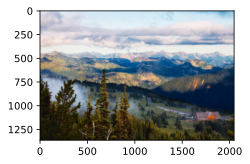

In [2]:
d2l.set_figsize()
content_img = Image.open('../img/rainier.jpg')
plt.imshow(content_img)

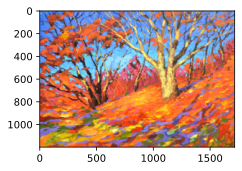

In [3]:
style_img = Image.open('../img/autumn-oak.jpg')
plt.imshow(style_img)

- 预处理和后处理

In [4]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

# 图片输入进来之后的预处理函数，转成tensor
def preprocess(img, image_shape):
    transforms = T.Compose([
        T.Resize(image_shape),
        T.ToTensor(),
        T.Normalize(mean=rgb_mean, std=rgb_std)
    ])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return T.ToPILImage()(img.permute(2, 0, 1))

- 在这里我们使用基于ImageNet数据集预训练好的VGG19来抽取特征

In [5]:
pretrained_net = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.DEFAULT)

- 为了避免保留过多content image的细节，我们选择比较顶层（靠后）的层来作为content的输出，为了保证样式融合的较好，我们选择几个层作为风格层，个人认为根据你想保留多少内容可以选择不同的content layer以及style layer

In [6]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

- 我们只需要从第0层到content_layer以及style_layer中最远的层的网络，后面的不需要

In [7]:
net = nn.Sequential(*[pretrained_net.features[i] for i in 
                      range(max(style_layers + content_layers) + 1)])

- 定义抽取特征的函数

In [8]:
def extract_features(X, content_layers, style_layers):
    contents, styles = [], []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

- 因为在模型迭代过程中无需对backbone进行调整，所以我们可以在模型训练开始的时候把content和style抽取好

In [9]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

- 定义损失函数
$$Loss = L_{content} + L_{style} + L_{tv}$$

In [10]:
def content_loss(Y_hat, Y):
    # 我们使用均方误差作为content loss
    return torch.square(torch.abs(Y_hat - Y.detach())).mean()

- 风格损失与内容损失类似，但是内容可以体现在RGB的取值上面，可是风格是整幅图片的风格，和RGB值本身无关，而是一个像素与周围像素的联系以及整体的RGB值的分布有关系，所以在这里我们定义风格损失，假设style输出的图片形状为$[c, h, w]$,我们把它展平成矩阵$\mathbf{X} \in \mathbf{R}^{c \times hw}$,那么每一行可以理解为是通道维度上的风格特征
- 在格拉姆（gram）矩阵$\mathbf{X}\mathbf{X}^T$中，i行j列的元素表示向量$\mathbf{x}_i · \mathbf{x}_j$，即表示了i和j通道上的风格的相关性
- 需要注意的是，当$hw$的值较大时，格拉姆矩阵中的元素容易出现较大的值。 此外，格拉姆矩阵的高和宽皆为通道数$c$,为了让风格损失不受这些值的大小影响，下面定义的gram函数将格拉姆矩阵除以了矩阵中元素的个数，即$chw$


In [11]:
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

In [12]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()


- 全变分损失，有时候我们学到的图像里面含有大量的噪声，由特别亮或者特别暗的像素颗粒，这个不是我们想看到的，一种常见的去噪方法是使用全变分去噪(total variation denoising)
$$L_{tv} = \sum_{i,j}{|x_{i,j} - x_{i+1,j}| + |x_{i,j} - x_{i, j + 1}|}$$

In [13]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() + 
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

- 计算总损失

In [14]:
content_weight, style_weight, tv_weight = 1, 1e3, 10
def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, gram_Y) * style_weight for Y_hat, gram_Y in zip(styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

- 初始化合成图像
- 在训练过程中，生成的图片是唯一需要进行改变的变量

In [15]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))
    
    def forward(self):
        return self.weight

In [16]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

- 模型训练

In [17]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    # X是合成的图像
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs], 
                            legend=['content', 'style', 'tv'], ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        # 下面是合成的图像抽取出来的content和style
        contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, 
                                                     styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if epoch % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)), float(sum(styles_l)), float(tv_l)])
    return X


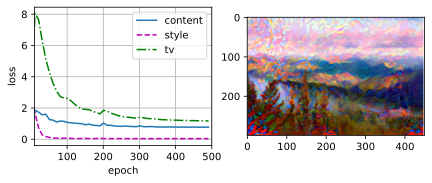

In [18]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

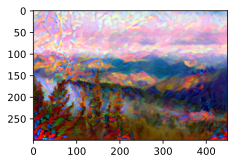

In [20]:
output_img = postprocess(output)
plt.imshow(output_img)


In [23]:
output_img.save('../img/output1.jpg')
content_img = output_img

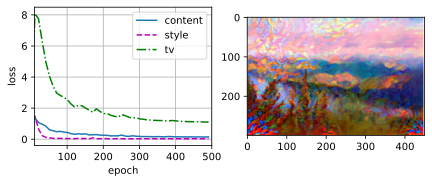

In [24]:
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

In [25]:
output_img2 = postprocess(output)
output_img2.save('../img/output2.jpg')